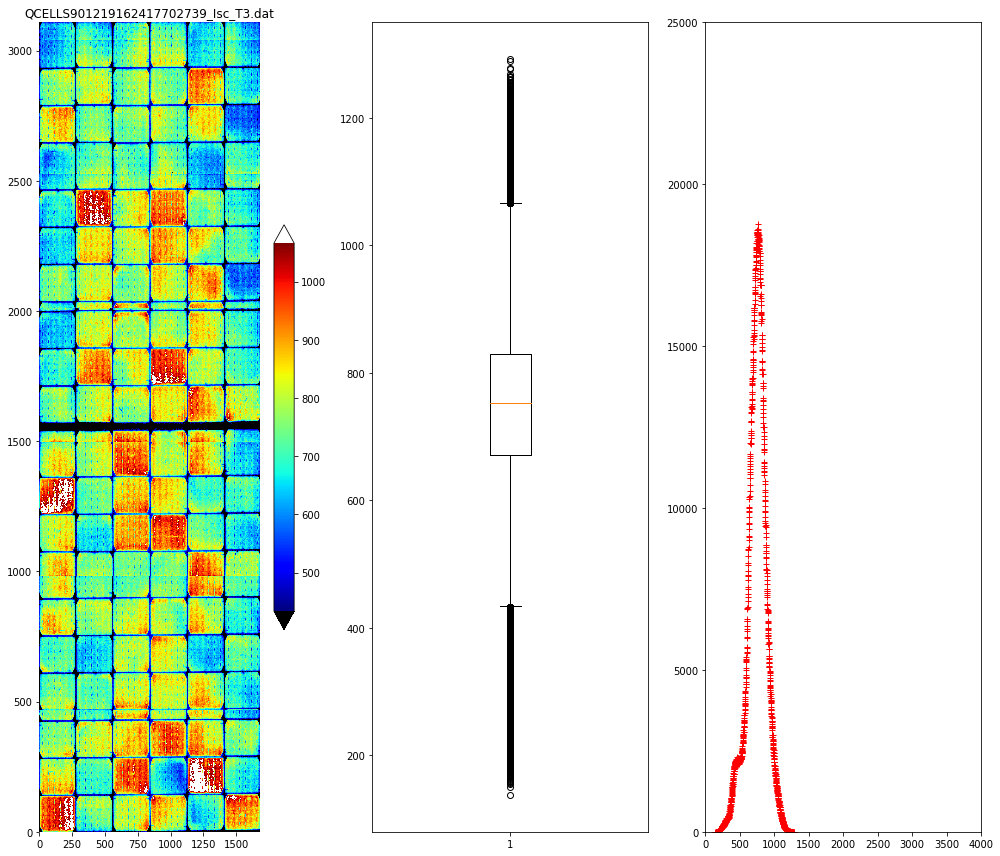

In [1]:
''' Creation: 2021.09.26
    Last update: 2021.10.01
    
    Electroluminecence greateyes raw images reading and plotting 
    
    '''



# Standard library import
import os.path
from pathlib import Path

# 3rd party imports
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

#Internal import 
import EL_image_analysis_Utils as pv

def histogram_equalize(img):
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    return np.interp(img, bin_centers, img_cdf)

def histogram():
    from collections import Counter
    x = electrolum.image.flatten()
    x.sort()
    y = Counter(x)
    axe[2].plot(y.keys(),y.values(),'r+')
    plt.xlim(0,4000)
    plt.ylim(0,25000)
    
def data_limit(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25

    val_min = q25 - iqr_nb_min*iqr
    val_max = q75 + iqr_nb_min*iqr
    return (val_min,val_max)

flag_crop = True
flag_pack = True
flag_rescale = False
flag_equalization = False
low_percentile = 0
high_percentile = 100
iqr_nb_min = 1.5
iqr_nb_max = 1.5
file_names = ["JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              "EL_Komma_Problem.dat",
              "QCELLS901019162417702754_Isc_T4.dat",
              "QCELLS901019162417702754_Isc_T5.dat",
              "QCELLS901019162417702754_Isc_Vérif.dat",
              "QCELLS901219162417702718_Isc_T0.dat", #5
              "QCELLS901219162417702718_Isc_T1.dat",
              "QCELLS901219162417702718_Isc_T2.dat",
              "QCELLS901219162417702719_Isc_T0.dat",
              "QCELLS901219162417702719_Isc_T1.dat", #10
              "QCELLS901219162417702719_Isc_T2.dat",
              "QCELLS901219162417702719_Isc_T3.dat",
              "QCELLS901219162417702739_Isc_T0.dat", #13
              "QCELLS901219162417702739_Isc_T1.dat",
              "QCELLS901219162417702739_Isc_T2.dat",
              "QCELLS901219162417702739_Isc_T3.dat",
              "QCELLS901619162417702749_Isc_T4.dat",
              "QCELLS901619162417702749_Isc_T5.dat",
              ]

file_name = file_names[16]

file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_name)

electrolum = pv.read_electolum_file(file,pack=flag_pack,crop=flag_crop)
if not flag_pack:
    fig = plt.figure(figsize=(16,12))
    gs = fig.add_gridspec(len(electrolum.image),2, hspace=0.5, wspace=0)
    axe = gs.subplots(sharex='col')
    for index, image in enumerate(electrolum.image):
            
        axe[index,0].imshow(image.astype(float),
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[index,0].spines[axis].set_linewidth(0)
        
        image_flatten = image.flatten()
        _ = axe[index,1].hist(image_flatten, bins='auto')
        axe[index,1].set_ylim([0,50000])
        
        file_gsf = os.path.splitext(file_name)[0] + '_' + str(index+1) + '.gsf'
        file_gsf = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
        #pv.py2gwyddion(image, file_gsf)
        
else: # Full image treatment
    image = electrolum.image.astype(float)
   
    fig,axe = plt.subplots(1,3,figsize=(14,12))
    if flag_rescale:
        p1, p2 = np.percentile(image, (low_percentile, high_percentile))
        image = exposure.rescale_intensity(image, in_range=(p1, p2))
        
    if flag_equalization:
        image = histogram_equalize(image)
        #image = 255*image/image.max()
        #image = image.astype(np.uint8)
        #image = cv2.equalizeHist(image)
    cmap =  matplotlib.cm.get_cmap("jet").copy()
    val_min,val_max = data_limit(image)
    im1 = axe[0].pcolormesh(image, cmap=cmap, vmin=val_min,vmax=val_max)
    im1.cmap.set_under('k')
    im1.cmap.set_over('w')
    cbar = plt.colorbar(im1,ax=axe[0],shrink=0.5,extend='both')

    
    
    #axe[0].imshow(image,
    #           cmap=cmap, #'gray','plasma','viridis','inferno','turbo'
    #          interpolation=None)
    for axis in ['top','bottom','left','right']:
        axe[0].spines[axis].set_linewidth(0)
    axe[0].set_title(file_name)

    #image_flatten = image.flatten()
    histogram()
    #_ = axe[1].hist(image.flatten(), bins='auto')
    flatten = image.flatten()
    filtered_data = flatten[~np.isnan(flatten)]
    _ = axe[1].boxplot(filtered_data)
    #axe[1].set_ylim([0,7*50000])

    file_gsf = os.path.splitext(file_name)[0] + '.gsf'
    file_gsf = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
    pv.py2gwyddion(image, file_gsf)
    plt.tight_layout()
plt.show()

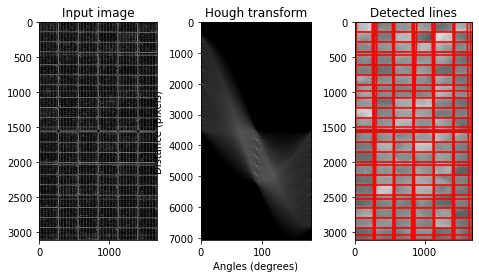

In [2]:
  
angle,d = pv.hough_transform(image)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 23 10:18:47 2022

@author: GR270188

This is a script to deal with EL images, it can plot all the images with the same scale
and also do auto cropping of the images if option is activated
put all raw tif 16 bit images in the same folder and select it throught the pop up window
"""
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
import tkinter
from tkinter.filedialog import askopenfilename, askdirectory
import datetime
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import PVcharacterization_Utils as pv
# option ######################################################################
option_scale = []#[min,max] or [] specify scale limits i.e. [0,35000]
option_color = 'gray'#'plasma','viridis','gray','inferno','turbo', etc.. type matplotlib.cm.get_cmap('abcd') in the console for full list
option_autocrop = "y"# "y" / "n"
autocrop_para = {'2D SG window_size':7,
                 '2D SG order':4,
                 'laplacian kernel size':7,
                 'laplacian kernel sigma':4,
                 'fraction of the std laplacian':5,
                 'ind_h_min':25,
                 'ind_h_max':1980}
#dirbase = 'H:/Python Scripts/EL'
dirbase = r'C:\Users\franc\PVcharacterization_files\EL'

# data and res folder #########################################################
rooot = tkinter.Tk()
rooot.geometry('+200+200')
rooot.attributes("-topmost", True)
rooot.withdraw()
rooot.lift()

data_folder = askdirectory(parent=rooot, title="Folder of all images",initialdir=dirbase)
pres=os.path.splitext(data_folder)[0]+'/EL '+datetime.datetime.now().strftime("%y-%m-%d %Hh%M")
os.mkdir(pres)

# open images #################################################################
file_fig = [f for f in glob.glob(data_folder+'/' + "**.tif", recursive=False)]
list_fig_name = [os.path.splitext(os.path.basename(f))[0] for f in file_fig]
list_im = []

print("importing images")
for i in tqdm(range(len(file_fig))):
    list_im.append(cv2.imread(file_fig[i],cv2.IMREAD_UNCHANGED))

dim_im = np.array([f.shape for f in list_im])

Cmax=0
for i in range(len(list_im)):
    list_im[i]=list_im[i][::-1,:]
    Cmax = np.amax([Cmax,list_im[i].max()])

print("saving images")
cmap = matplotlib.cm.get_cmap(option_color).copy()
cmap.set_over('green')
cmap.set_under('green')
plt.ioff() #plt.ion() #
gs = matplotlib.gridspec.GridSpec(1, 1)
if len(option_scale)==2:
    print("using "+ str(option_scale[0])+" to "+str(option_scale[1]) +" as color scale")
    c_scale = option_scale
    if option_scale[1]<Cmax:
        print("WARNING: max color scale is "+str(option_scale[1]) +" but max data is "+str(Cmax) +" some pixels will be out of scale")
    
else:
    c_scale = [0,Cmax]

for i in tqdm(range(len(file_fig))):
    fig10 = plt.figure(10,figsize=(dim_im[i,1]/400, dim_im[i,0]/400))
    ax10 = fig10.add_subplot(gs[0, 0])
    ax10.imshow(list_im[i],cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])#
    ax10.set_axis_off()
    fig10.tight_layout(pad=0)
    fig10.savefig(pres+'/'+list_fig_name[i]+'.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
    plt.close(fig10)

fig100 = plt.figure(100,figsize=(dim_im[0,1]/400, dim_im[0,0]/400))
gs = matplotlib.gridspec.GridSpec(1, 4)
ax100 = fig100.add_subplot(gs[0, :-1])
ax100im = ax100.imshow(list_im[i],cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])
ax100.set_axis_off()
#fig100.tight_layout(pad=0)
axin100 = inset_axes(ax100,width="4%",height="100%",loc='lower left',bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=ax100.transAxes,borderpad=0,)
ccbar1 = plt.colorbar(ax100im,cax=axin100)#, format='%.5d'
#ccbar1.ax.tick_params(labelsize=tiksiz)
ccbar1.set_label('Intensity (Arb. U.)')
axin100.text(1.8*axin100.get_xlim()[1],1.05*c_scale[1]-c_scale[0],str(c_scale[1]))
axin100.text(1.8*axin100.get_xlim()[1],-0.05*c_scale[1]-c_scale[0],str(c_scale[0]), verticalalignment='top')
fig100.savefig(pres+'/'+'@scale.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
plt.close(fig100)

plt.ion()



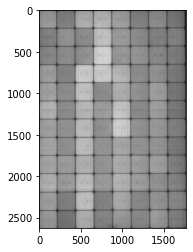

In [3]:
#Internal import 
import EL_image_analysis_Utils as pv

from matplotlib import image
import cv2#pip install opencv-python
import matplotlib.pyplot as plt
file_names = ["JINERGY3272023326035_Isc_T2.tif",
              "JINERGY3272023326035_Isc_T1.tif",
              "Panasonic_W3AKSNH15247_600mA_6000ms.tif",
              ]

file_name = file_names[2]

file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_name)

# load image as pixel array
image = image.imread(file)

#array_im_red = pv.ines_crop(image,autocrop_para)
image_crop = pv.icrop_image_basic(image)

plt.imshow(image_crop,
                   cmap='gray', 
                   interpolation=None)

(array([-0.5027933, -0.5027933, -0.5027933, -0.5027933, -0.5027933,
        -0.5027933, -0.5027933, 90.       , -0.5027933, 90.       ,
        90.       , 90.       , 90.       , 90.       , 90.       ,
        90.       , 90.       , -0.5027933, 90.       , 90.       ,
        -0.5027933, -0.5027933, -0.5027933, -0.5027933, -0.5027933,
        -0.5027933, 90.       , -0.5027933, -0.5027933, -0.5027933,
        -0.5027933, 90.       , 90.       ]),
 array([1.53874301e+03, 1.31670795e+03, 1.09367272e+03, 8.69637340e+02,
        6.46602117e+02, 1.71877144e+03, 1.57774917e+03, 2.14783920e+03,
        1.64776023e+03, 5.00078976e-01, 1.96781077e+03, 1.09267256e+03,
        4.35568789e+02, 6.54603380e+02, 1.53074175e+03, 2.16534197e+02,
        1.30970684e+03, 1.49673638e+03, 8.72637814e+02, 1.74677586e+03,
        4.23566893e+02, 1.42572516e+03, 1.75777760e+03, 1.27470131e+03,
        1.35471395e+03, 1.20369010e+03, 1.19268836e+03, 1.13167872e+03,
        2.01531828e+02, 7.56619491e+02, 8.

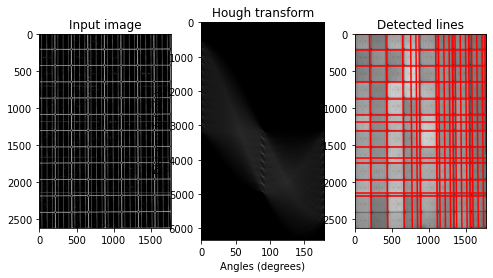

In [4]:
pv.hough_transform(image_crop)

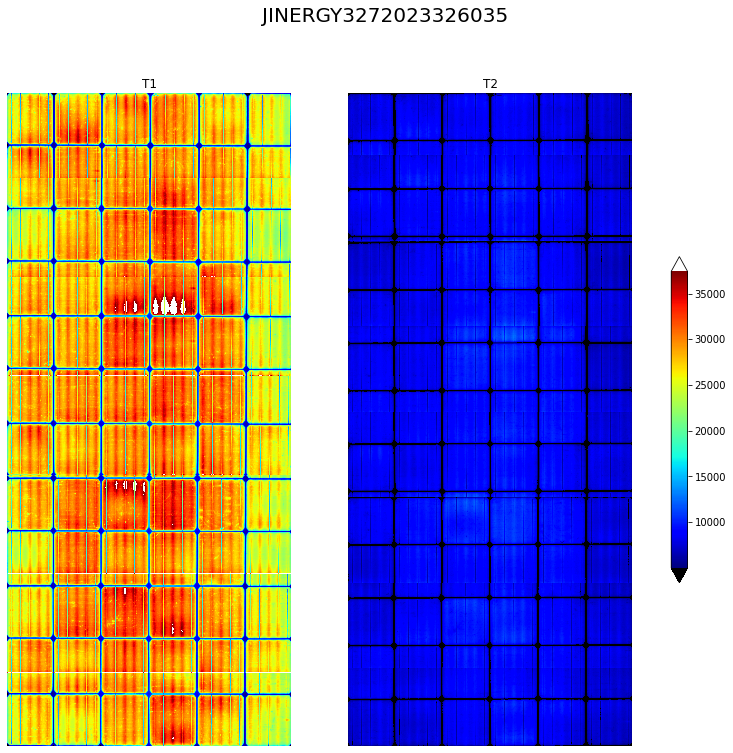

In [5]:
''' Creation: 2022.07.20
    Last update: 2022.07.20
    
    Electroluminecence greateyes raw images reading and plotting 
    
    '''



# Standard library import
import os.path
import re
from pathlib import Path

# 3rd party imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Internal import 
import EL_image_analysis_Utils as pv

    
def data_limit(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25

    val_min = q25 - iqr_nb_min*iqr
    val_max = q75 + iqr_nb_min*iqr
    return (val_min,val_max)

motif = re.compile(r'T\d')

iqr_nb_min = 1.5
iqr_nb_max = 1.5

file_names = [
              "JINERGY3272023326035_Isc_T1.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "EL_Komma_Problem.dat",
              "QCELLS901019162417702754_Isc_T4.dat",
              "QCELLS901019162417702754_Isc_T5.dat",
              "QCELLS901019162417702754_Isc_Vérif.dat",#5
              "QCELLS901219162417702718_Isc_T0.dat", 
              "QCELLS901219162417702718_Isc_T1.dat",
              "QCELLS901219162417702718_Isc_T2.dat",
              "QCELLS901219162417702719_Isc_T0.dat",
              "QCELLS901219162417702719_Isc_T1.dat", #10
              "QCELLS901219162417702719_Isc_T2.dat",
              "QCELLS901219162417702719_Isc_T3.dat",
              "QCELLS901219162417702739_Isc_T0.dat", #13
              "QCELLS901219162417702739_Isc_T1.dat",
              "QCELLS901219162417702739_Isc_T2.dat",
              "QCELLS901219162417702739_Isc_T3.dat",
              "QCELLS901619162417702749_Isc_T4.dat",
              "QCELLS901619162417702749_Isc_T5.dat",
              ]

file_index = [0,1]
image_list = []
val_min_list = []
val_max_list = []

for index in file_index:
    file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_names[index])
    electrolum = pv.read_electolum_file(file,pack=True,crop=True)
    
    image = electrolum.image.astype(float)
    image_list.append(image)
    val_min,val_max = data_limit(image)
    val_min_list.append(val_min)
    val_max_list.append(val_max)
        
val_min = min(val_min_list)
val_max = max(val_max_list)

fig,axe = plt.subplots(1,len(image_list),figsize=(14,12))  

for loop_counter,image in  enumerate(image_list):
    try:
        ax = axe[loop_counter]
    except:
        ax = axe
    cmap =  matplotlib.cm.get_cmap("jet").copy()
    im1 = ax.pcolormesh(image, cmap=cmap, vmin=val_min,vmax=val_max)
    im1.cmap.set_under('k')
    im1.cmap.set_over('w')
    
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0)
    ax.set_title(motif.findall(file_names[file_index[loop_counter]])[0])
    ax.axis('off')

cbar = plt.colorbar(im1,ax=(axe),shrink=0.5,extend='both')
fig.suptitle(file_names[file_index[0] ].split('_')[0], fontsize=20)
plt.show()
